In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import RootMeanSquaredError
from scipy.ndimage import uniform_filter1d

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.decomposition import PCA

Use only feature 'Adj Close'

model 1 

In [189]:



start = '2000-01-01'
end = datetime(2024, 8, 7, 11, 21, 24, 633194)

sp500_data = yf.download('^GSPC', start='2000-03-14', end='2024-01-01')
sp500 = sp500_data.dropna()
print(sp500.head(3))

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-03-14  1383.619995  1395.150024  1359.150024  1359.150024  1359.150024   
2000-03-15  1359.150024  1397.989990  1356.989990  1392.140015  1392.140015   
2000-03-16  1392.150024  1458.469971  1392.150024  1458.469971  1458.469971   

                Volume  
Date                    
2000-03-14  1094000000  
2000-03-15  1302800000  
2000-03-16  1482300000  


In [190]:
data = sp500.filter(['Adj Close'])
#convert the dataframe to a numpy array
dataset = data.values
train_data_len = int(np.round(0.8 * dataset.shape[0]))
train_data_len

4790

In [191]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:train_data_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(4730, 60, 1)

In [192]:
test_data = scaled_data[train_data_len - 60:, :]
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test= np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(1198, 60, 1)

In [193]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4730, 60, 1), (4730,), (1198, 60, 1), (1198, 1))

In [194]:
tf.random.set_seed(42)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - loss: 1.6113e-04 - val_loss: 5.6176e-05
Epoch 2/2
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 5.5380e-05 - val_loss: 6.3414e-05


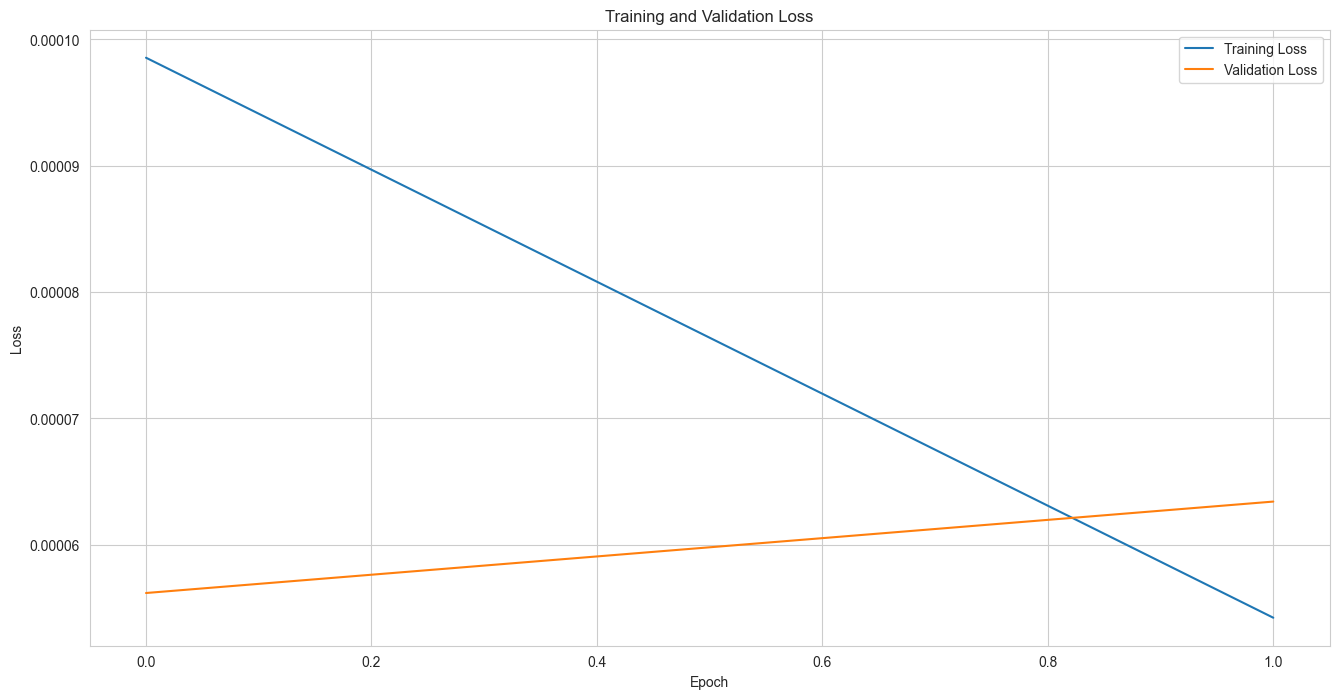

In [195]:
history=model.fit(x_train,y_train,epochs=2,batch_size=2,validation_split=0.2)

# Plot the training and validation loss
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [196]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


98.36658917400077

We can see both from our rmse and the train validation loss mour model here did a terriable job, however, when look at the model below, it looks we get a good resutls anyway. 

/var/folders/py/r18r2psx509b19yt58bj8b300000gn/T/ipykernel_56829/3729137219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


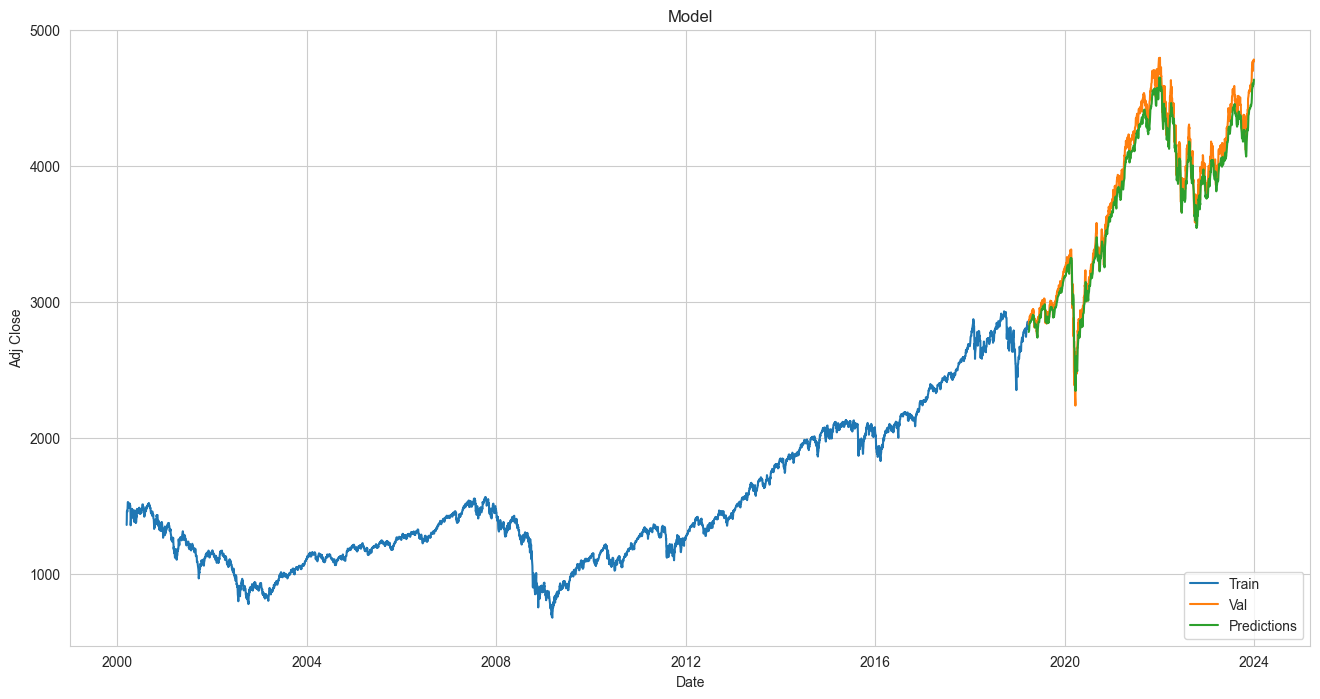

In [197]:
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

/var/folders/py/r18r2psx509b19yt58bj8b300000gn/T/ipykernel_56829/1264031377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


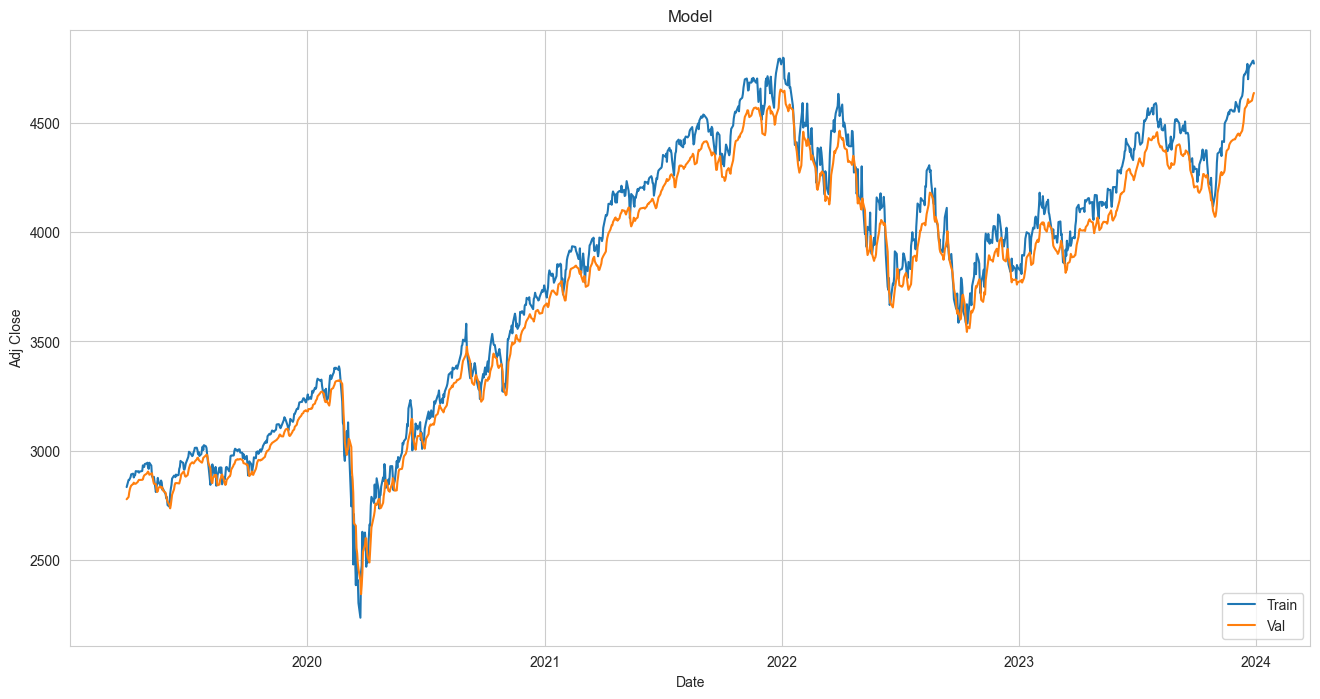

In [198]:
valid = data[train_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

model 3--final model 

[*********************100%%**********************]  8 of 8 completed


Text(0.5, 1.0, 'Correlation of stock closing price')

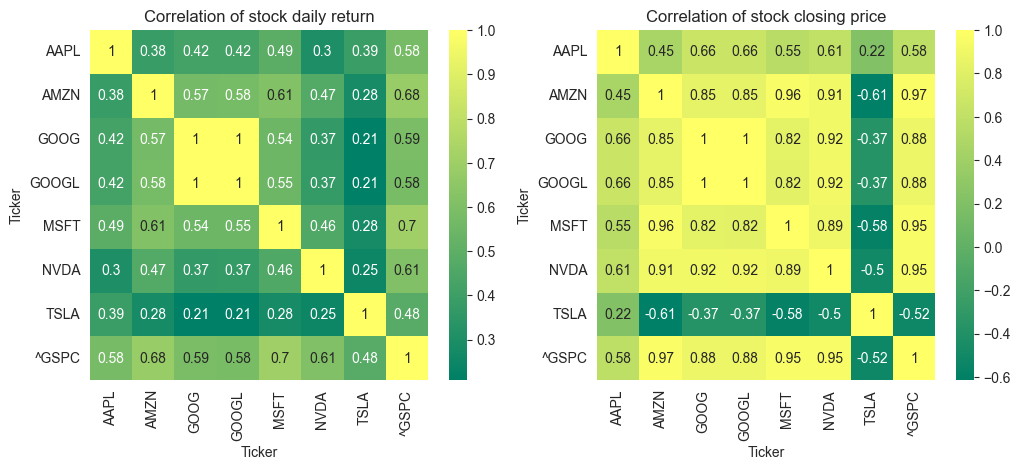

In [201]:
# Fetch the adjusted closing prices for the tech stocks
tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', '^GSPC']
closing_df = yf.download(tickers, start=start, end=end)['Adj Close']
tech_rets = closing_df.pct_change()


plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock daily return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

In [10]:
end = datetime(2024, 8, 7, 11, 21, 24, 633194)
start = '2000-01-01'

# Fetch daily S&P 500 data
sp500_data = yf.download('^GSPC', start=start, end=end)


# Add technical indicators
sp500_data['Rsi'] = ta.rsi(sp500_data['Adj Close'], length=14)  
sp500_data['Ema_fast'] = ta.ema(sp500_data['Adj Close'], length=12)  
sp500_data['Ema_medium'] = ta.ema(sp500_data['Adj Close'], length=26)  
sp500_data['Ema_slow'] = ta.ema(sp500_data['Adj Close'], length=50) 
sp500_data['Sma_30'] = ta.sma(sp500_data['Adj Close'], length=30)  
sp500_data['Sma_100'] = ta.sma(sp500_data['Adj Close'], length=100)  

sp500_data['Bollinger_High'] = ta.bbands(sp500_data['Adj Close'], length=20, std=2)['BBU_20_2.0']
sp500_data['Bollinger_Low'] = ta.bbands(sp500_data['Adj Close'], length=20, std=2)['BBL_20_2.0']

sp500_data['ATR'] = ta.atr(sp500_data['High'], sp500_data['Low'], sp500_data['Adj Close'], length=14)
sp500_data['MACD'] = ta.macd(sp500_data['Adj Close'], fast=12, slow=26, signal=9)['MACD_12_26_9']

print(sp500_data.head())

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971  1455.219971   
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1399.420044   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1402.109985   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1403.449951   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1441.469971   

                Volume  Rsi  Ema_fast  Ema_medium  Ema_slow  Sma_30  Sma_100  \
Date                                                                           
2000-01-03   931800000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-04  1009000000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-05  1085500000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-06  1092300000  NaN       NaN         